## Calculate differences
- Calculate differences using different models on the effect of Sad vs. Neutral on hippocampus

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

# regular GLMs
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
## Load amygdala database
df = pd.read_csv('SadvsNeutral.csv')
# create a long format for analysis
df_long = pd.melt(df, id_vars=['scr_id','groupIdx'], value_vars=['vmpfc1','vmpfc2','vmpfc3'])
df_long

,scr_id,groupIdx,variable,value
0,KPE008,1,vmpfc1,-0.063031
1,KPE1223,1,vmpfc1,0.704947
2,KPE1253,0,vmpfc1,0.160294
3,KPE1263,0,vmpfc1,0.531784
4,KPE1293,1,vmpfc1,0.601268
...,...,...,...,...
73,KPE1561,0,vmpfc3,0.510941
74,KPE1573,1,vmpfc3,0.646336
75,KPE1578,0,vmpfc3,0.195809
76,KPE1587,1,vmpfc3,NaN


In [4]:
## Start with simple GLM models (using statsmodel)
glm = smf.mixedlm('value ~ variable + groupIdx', data=df_long, groups = df_long.scr_id, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   value   
No. Observations:    73        Method:               REML    
No. Groups:          26        Scale:                0.1364  
Min. group size:     2         Log-Likelihood:       -44.1351
Max. group size:     3         Converged:            Yes     
Mean group size:     2.8                                     
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           0.264    0.106  2.500 0.012  0.057  0.471
variable[T.vmpfc2] -0.164    0.104 -1.578 0.114 -0.367  0.040
variable[T.vmpfc3] -0.234    0.108 -2.160 0.031 -0.445 -0.022
groupIdx           -0.034    0.125 -0.271 0.786 -0.279  0.211
Group Var           0.052    0.096                           



In [5]:
# mixed anova
aov = pg.mixed_anova(data=df_long, dv='value', between='groupIdx', within='variable',
                     subject='scr_id', correction=False, effsize="np2")
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
groupIdx     0.020      1     19  0.020  0.064    0.802  0.003  nan
variable     0.529      2     38  0.265  1.696    0.197  0.082    0.748
Interaction  0.020      2     38  0.010  0.065    0.937  0.003  nan



## Build a Bayesian model
- Here we would model each subject under each group

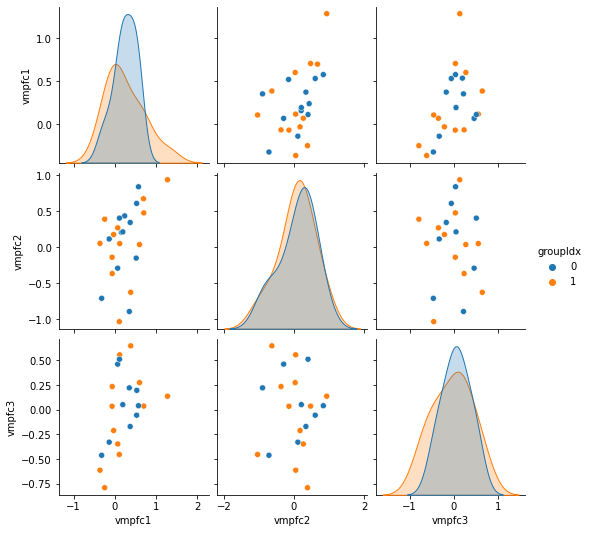

In [6]:
# first lets look at the data
sns.pairplot(df[['vmpfc1','vmpfc2','vmpfc3','groupIdx']], hue='groupIdx', kind='scatter')

In [7]:
df_long.groupby(['groupIdx', 'variable']).describe()

value                                                    \
                  count      mean       std       min       25%       50%   
groupIdx variable                                                           
0        vmpfc1    13.0  0.247569  0.274096 -0.318908  0.114160  0.240341   
         vmpfc2    12.0  0.092010  0.518918 -0.896479 -0.188134  0.209309   
         vmpfc3    10.0  0.046362  0.315672 -0.461565 -0.141606  0.045723   
1        vmpfc1    13.0  0.247054  0.463174 -0.360004 -0.063031  0.109410   
         vmpfc2    13.0  0.067371  0.531102 -1.037346 -0.141071  0.051336   
         vmpfc3    12.0 -0.041420  0.449943 -0.789959 -0.373746  0.035562   

                                       
                        75%       max  
groupIdx variable                      
0        vmpfc1    0.520635  0.576824  
         vmpfc2    0.411079  0.839231  
         vmpfc3    0.214643  0.510941  
1        vmpfc1    0.601268  1.281488  
         vmpfc2    0.388151  0.936885  
         vmpfc3    0.244183  0.646336

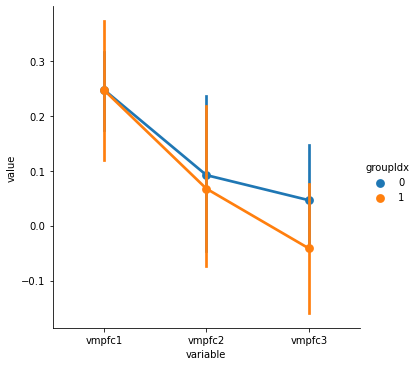

In [8]:
sns.catplot(y='value',x='variable', hue='groupIdx', data=df_long, kind='point', ci=68)


In [9]:
# take indexes for building the model
df_long['scr_id'] = df_long.scr_id.astype('category')
sub_idx = df_long.scr_id.cat.codes.values # get county category index values (613 x 1) vec with nums [0-7]
print(sub_idx)
n_subs = len(np.unique(df_long.scr_id))
print(n_subs)
# set time as index also
#df_long.groupIdx = pd.Categorical(df_long.groupIdx)
df_long.variable = pd.Categorical(df_long.variable, 
                    categories=['vmpfc1','vmpfc2','vmpfc3'])
timeIDX = df_long.variable.cat.codes.values
print(timeIDX)
df_long['time'] = timeIDX


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21
 22 23 24 25  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
 20 21 22 23 24 25]
26
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2]


In [10]:
## Run similar model but without hyperpriors
# now we build a model - modeling the score of each group on each time point
with pm.Model() as hierarchical:
      
    a = pm.Normal('a', mu=0, sd=0.1, shape=n_subs)
       
    b = pm.Normal('b', mu=0, sd=0.1, shape=3)
    
  
    # Model error
    eps = pm.HalfCauchy('eps', 1)

    y_hat = a[sub_idx] + b[timeIDX] 

    # Data likelihood
    likelihood = pm.Normal('likelihood', mu=y_hat,
                           sigma=eps, observed=df_long.value)
    
    trace = pm.sample(draws=4000, tune=1000, target_accept=0.9, return_inferencedata=True, cores=6)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [likelihood_missing, eps, b, a]


Sampling 6 chains for 1_000 tune and 4_000 draw iterations (6_000 + 24_000 draws total) took 8 seconds.


In [11]:
az.summary(trace, hdi_prob=.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.019,0.092,-0.172,0.128,0.000,0.001,39726.0,19043.0,1.0
a[1],0.052,0.094,-0.105,0.201,0.000,0.001,44066.0,18312.0,1.0
a[2],0.010,0.095,-0.145,0.168,0.001,0.001,34968.0,18788.0,1.0
a[3],0.044,0.092,-0.102,0.198,0.000,0.001,44106.0,17276.0,1.0
a[4],0.036,0.093,-0.112,0.192,0.000,0.001,38828.0,18635.0,1.0
a[5],0.027,0.092,-0.123,0.179,0.000,0.001,37051.0,19273.0,1.0
a[6],0.107,0.094,-0.046,0.260,0.000,0.000,40479.0,19204.0,1.0
a[7],-0.055,0.093,-0.207,0.095,0.000,0.001,37420.0,18947.0,1.0
a[8],-0.010,0.094,-0.164,0.141,0.000,0.001,40220.0,17479.0,1.0
a[9],0.002,0.092,-0.151,0.154,0.000,0.001,41487.0,17771.0,1.0


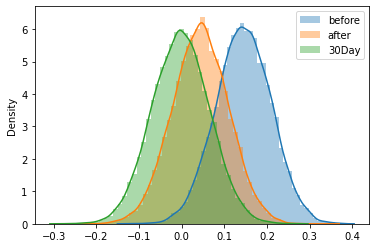

In [17]:
sns.distplot(trace.posterior['b'].data[:,:,0], label='before')
sns.distplot(trace.posterior['b'].data[:,:,1], label='after')
sns.distplot(trace.posterior['b'].data[:,:,2], label='30Day')
plt.legend()

0.05675

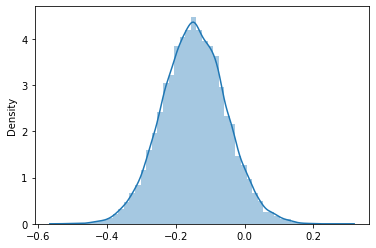

In [13]:
diffTime = trace.posterior['b'].data[:,:,2] - trace.posterior['b'].data[:,:,0]
sns.distplot(diffTime)
sum(diffTime.ravel()>0)/len(diffTime.ravel())

## Next we calculate the difference between the groups in each time
- Althgough the interaction wasn't significant, we still look at this one - as there's a group difference

In [12]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('vmpfc1 ~ groupIdx', df)
    traceSes1 = pm.sample(return_inferencedata=True)
az.summary(traceSes1, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.249,0.113,0.074,0.442,0.003,0.002,1556.0,1740.0,1.0
groupIdx,-0.003,0.158,-0.244,0.264,0.004,0.003,1517.0,1878.0,1.0
sd,0.401,0.062,0.306,0.500,0.001,0.001,2366.0,1933.0,1.0


In [13]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('vmpfc2 ~ groupIdx', df)
    traceSes2 = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [14]:
az.summary(traceSes2, hdi_prob=.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.092,0.162,-0.172,0.364,0.004,0.003,1809.0,1780.0,1.0
groupIdx,-0.026,0.227,-0.410,0.330,0.005,0.004,1810.0,1894.0,1.0
sd,0.552,0.089,0.424,0.699,0.002,0.001,1813.0,1678.0,1.0


In [15]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('vmpfc3 ~ groupIdx', df)
    traceSes3 = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.889497413848696, but should be close to 0.8. Try to increase the number of tuning steps.


In [16]:
az.summary(traceSes3, hdi_prob=.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.045,0.140,-0.174,0.279,0.003,0.002,1938.0,2144.0,1.0
groupIdx,-0.086,0.190,-0.377,0.237,0.004,0.003,1885.0,1997.0,1.0
sd,0.422,0.074,0.306,0.535,0.002,0.001,1988.0,1770.0,1.0


## Using a different method for assessing

In [19]:
## create a function that will simply run the model for each session
def runModel(variable):
    with pm.Model() as hierarchical:
      
        a = pm.Normal('a', mu=0, sd=1) 
        bMed = pm.Normal('bMed', mu=0, sd=1, shape=2) #

        # Model error
        eps = pm.HalfCauchy('eps', 5)

        y_hat = a + bMed[df.groupIdx]

        # Data likelihood
        likelihood = pm.Normal('likelihood', mu=y_hat,
                               sigma=eps, observed=df[str(variable)])

        trace = pm.sample(draws=4000, tune=2000,target_accept=0.9, return_inferencedata=False, cores = 6)
        diff = trace['bMed'][:,1] - trace['bMed'][:,0]
    return trace, diff

In [20]:
ses1trace, ses1Diff = runModel('vmpfc1')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [eps, bMed, a]


Sampling 6 chains for 2_000 tune and 4_000 draw iterations (12_000 + 24_000 draws total) took 21 seconds.


Group difference is 0.4980833333333333


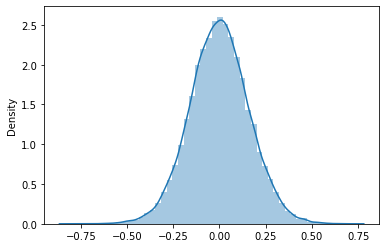

In [21]:
pm.summary(ses1trace)
sns.distplot(ses1Diff)
print(f'Group difference is {sum(ses1Diff>0)/len(ses1Diff)}')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [likelihood_missing, eps, bMed, a]


Sampling 6 chains for 2_000 tune and 4_000 draw iterations (12_000 + 24_000 draws total) took 21 seconds.


Group difference is 0.45458333333333334


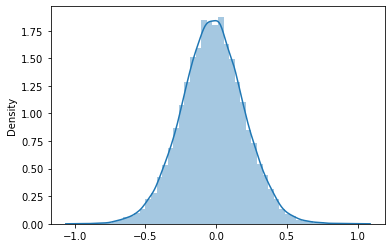

In [22]:
ses2trace, ses2Diff = runModel('vmpfc2')
pm.summary(ses2trace)
sns.distplot(ses2Diff)
print(f'Group difference is {sum(ses2Diff>0)/len(ses2Diff)}')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [likelihood_missing, eps, bMed, a]


Sampling 6 chains for 2_000 tune and 4_000 draw iterations (12_000 + 24_000 draws total) took 29 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Group difference is 0.31104166666666666


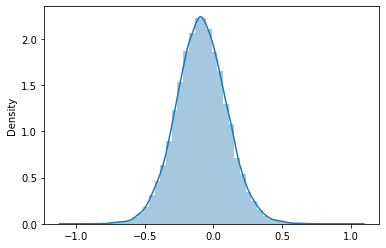

In [23]:
ses3trace, ses3Diff = runModel('vmpfc3')
pm.summary(ses3trace)
sns.distplot(ses3Diff)
print(f'Group difference is {sum(ses3Diff>0)/len(ses3Diff)}')

## Plotting

In [ ]:
# set variables
def plotDiff(depVar,indepVar, trace):
    sns.set_style("ticks") # set style
    y = str(depVar)
    dfPlot = df
    ci = np.quantile(trace.posterior[str(indepVar)], [.05,.95])
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(3, 5),gridspec_kw={'width_ratios': [1, .2],
                                                            'wspace':.1})
    g1 = sns.stripplot(y= y, x='group', data=dfPlot, size = 8, ax=ax1)
    sns.boxplot(y= y, x='group', data=dfPlot,  ax=ax1,
                boxprops=dict(alpha=.3))
    g2 = sns.distplot(trace.posterior[str(indepVar)], ax = ax2, vertical=True)
    ax2.vlines(x=0.001,ymin=ci[0], ymax=ci[1], color='black', 
               linewidth = 3, linestyle = "-")

    #g3.set_ylim(-.7, .7)
    #ax1.set_ylim(-.7,.7)
    ax2.set_ylim(g1.get_ylim()) # use first graph's limits to get the relevant for this one
    ax2.yaxis.tick_right()
    ax2.set_xticks([])
    ax2.set_ylabel("Difference between groups", fontsize=14) 
    ax2.yaxis.set_label_position("right")
    ax1.set_ylabel("vmPFC reactivity to sad script", fontsize=12)
    ax1.set_xlabel("Group", fontsize=14)
    fig.savefig( str(depVar) + 'Reactivity.png', dpi=300, bbox_inches='tight')
    return fig

In [ ]:
plt.figure(figsize=(30,30))
ax1 = plotDiff('vmpfc1','groupIdx',traceSes1)
ax2 = plotDiff('vmpfc2','groupIdx',traceSes2)
ax3 = plotDiff('vmpfc3','groupIdx',traceSes3)